In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display, Markdown, Latex

# Santa Maria Prediction

I'm waaaay out of my lane here, but I decided to fit an exponential curve to the Santa Maria cases and see what it looks like. It looks like it fits well, and it looks like Santa Maria could rack up 5,000 cases within a couple of months if things continue on this track. 

...but, and I can't stress this enough, I'M NOT AN EPIDEMIOLOGIST! (in fact I'm not even sure I spelled epidemiologist right) I'm mostly just doing this as a exercise to learn some new technology and brush up on some math that I've half forgotten.

In [2]:
tclong = pd.read_pickle('tclong.pickle')

In [3]:
sm = tclong.query('`Geographic Area` == "City Of Santa Maria"')

In [4]:
df = sm.pivot(index='Day of the Year', columns='Geographic Area', values='Count')
df.rename({'City Of Santa Maria': 'Count'}, axis='columns', inplace=True)

In [5]:
df.reset_index(inplace=True)

In [6]:
def transformed_regression(x, y):
    """
    Regress log transform of y on x and return A and B values for y = A * exp(B * x).
    These estimates are biased, but they'll do for estimates to supply to curve_fit.
    """
    res = stats.linregress(x, np.log(y))
    B = res.slope
    logA = res.intercept
    rval = res.rvalue
    A = np.exp(logA)
    return A, B

def easy_curve_fit(x, y):
    """
    Estimate A and B with regression, then use those to initialize optimized curve_fit
    from scipy.
    """
    A, B = transformed_regression(x, y)
    (Aopt, Bopt), pcov = curve_fit(lambda x, a, b: a*np.exp(b*x), x, y, p0=(A, B))
    return Aopt, Bopt, pcov

def predict_and_extend(df, n_days_forward=120):
    x = df['Day of the Year'].values
    y = df['Count'].values
    A, B, pcov = easy_curve_fit(x, y)
    exp_func = lambda x: A*np.exp(B*x)
    xfit = np.arange(x.min(), x.max() + n_days_forward, 1)
    model = pd.DataFrame(
        {
            'Day of the Year': xfit,
            'Modeled Count': exp_func(xfit)
        }
    )
    model = model.set_index('Day of the Year').join(df.set_index('Day of the Year'))
    model['Date'] = pd.to_datetime(model.index.to_series().apply(lambda i: '2020 ' + str(i)), format='%Y %j')
    return model, pcov

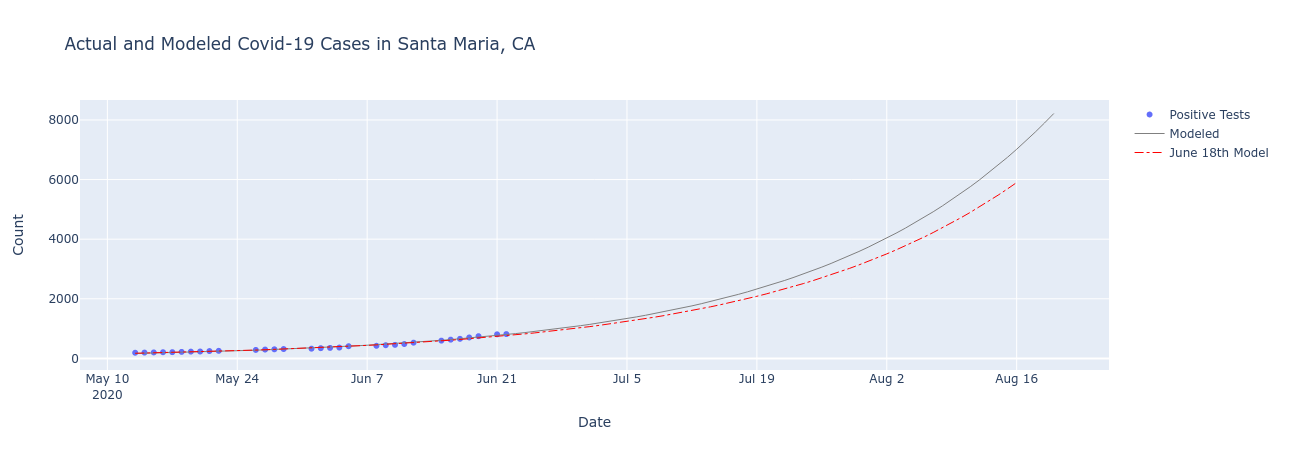

In [7]:
mod, pcov = predict_and_extend(df, 60)
imod, ipcov = predict_and_extend(df[df['Day of the Year'] <= 170], 60)
mod['Date'] = pd.to_datetime(mod.index.to_series().apply(lambda i: '2020 ' + str(i)), format='%Y %j')
fig = go.Figure() #px.scatter(mod, x='Date', y='Count', labels='Confirmed Cases')
fig.add_trace(go.Scatter(
    x=mod.Date, y=mod.Count,
    mode='markers', name='Positive Tests'))
fig.add_trace(go.Scatter(
    x=mod.Date, y=mod['Modeled Count'], 
    mode='lines', name='Modeled', line=dict(width=1, color='gray')))
fig.add_trace(go.Scatter(
    x=imod.Date, y=imod['Modeled Count'], 
    mode='lines', name='June 18th Model', line=dict(dash='dashdot', width=1, color='red')))
fig.update_layout(title='Actual and Modeled Covid-19 Cases in Santa Maria, CA',
                   xaxis_title='Date',
                   yaxis_title='Count')
pio.write_html(fig, 'SM_model.html')
fig.show()

In [8]:
x = df['Day of the Year'].values
y = df['Count'].values
A, B, pcov = easy_curve_fit(x, y)

growth_rate = 100*(np.exp(B) - 1)
double_days = np.log(2) / B

Markdown(
    f"The modeled growth rate in Santa Maria is {growth_rate:.2}% daily. At that rate, cases will double every {double_days:.1f} days."
)

The modeled growth rate in Santa Maria is 4.0% daily. At that rate, cases will double every 17.6 days.

## Just for the heck of it

I've "modeled" the other geographic areas. Some of these look very dubious. I need to look at the covariance matrices to see how good these fits are, and I need to calculate some measures of uncertainty. This is a work in progress, and these plots are little more than wild speculation at the moment.

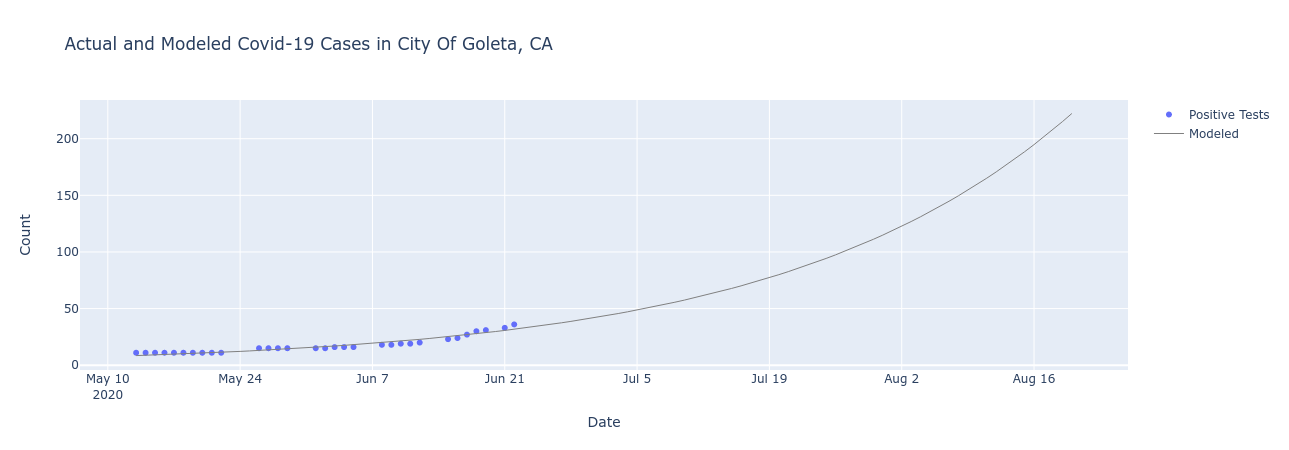

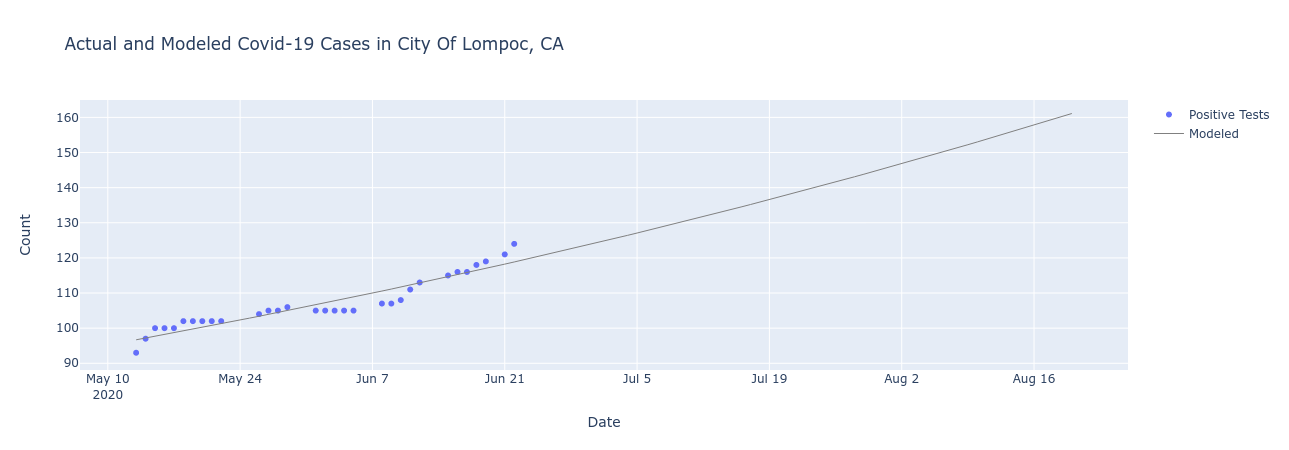

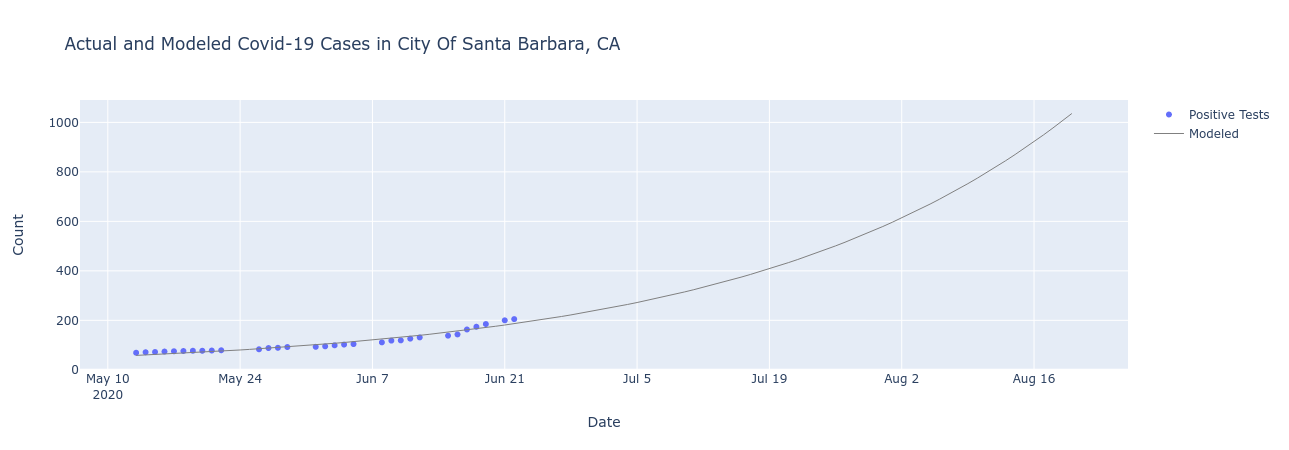

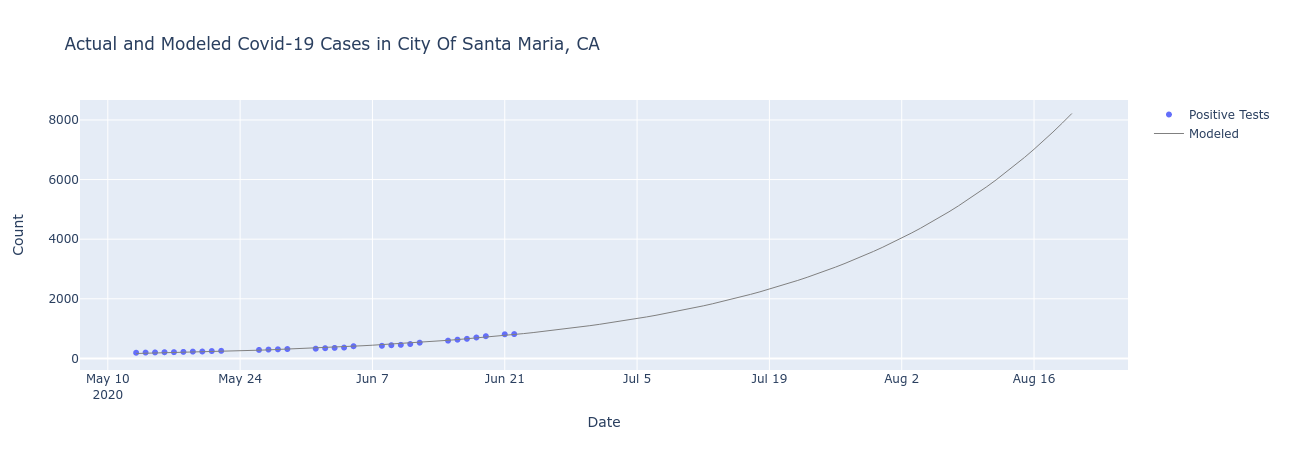

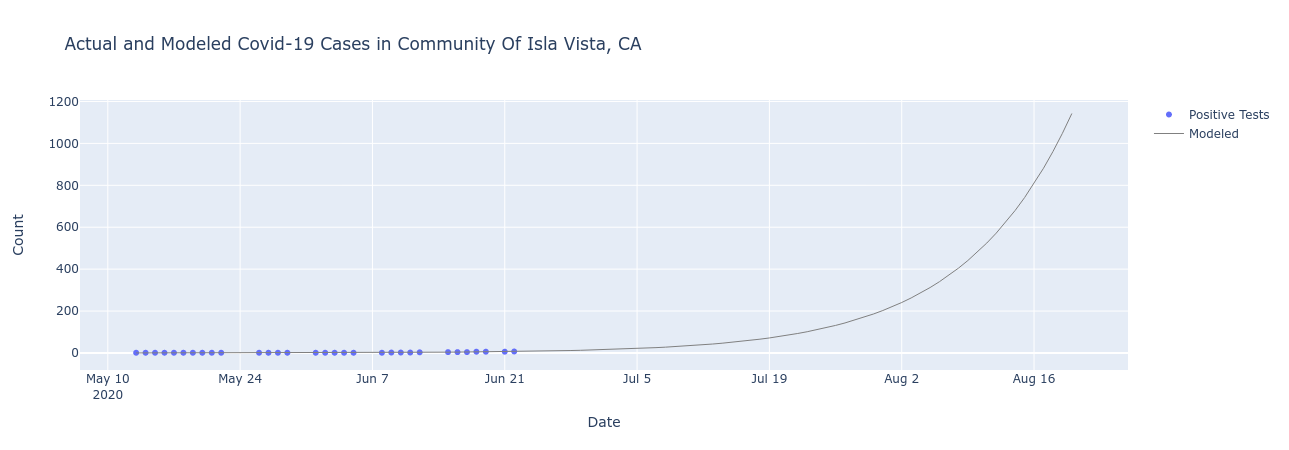

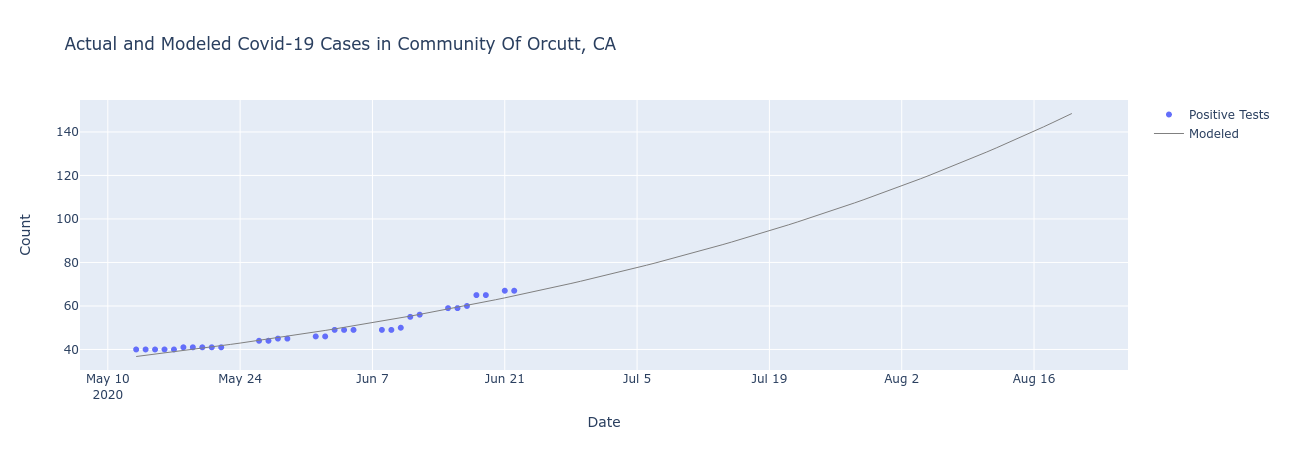

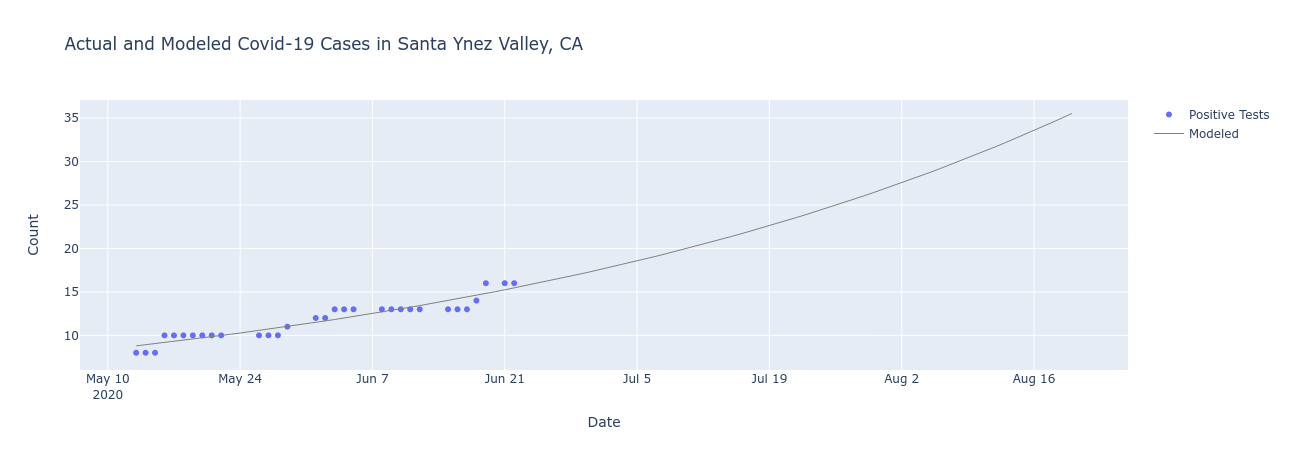

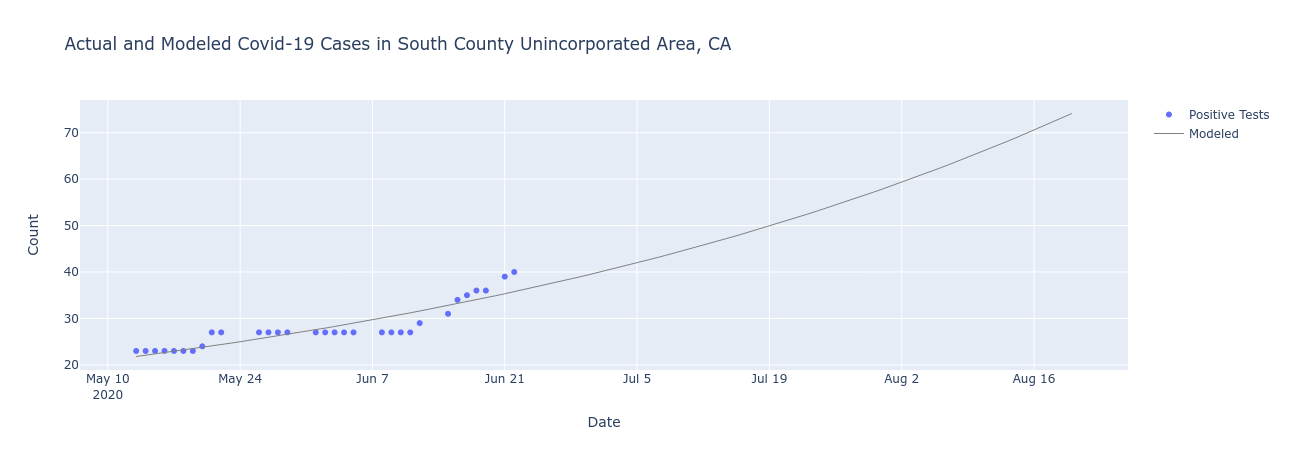

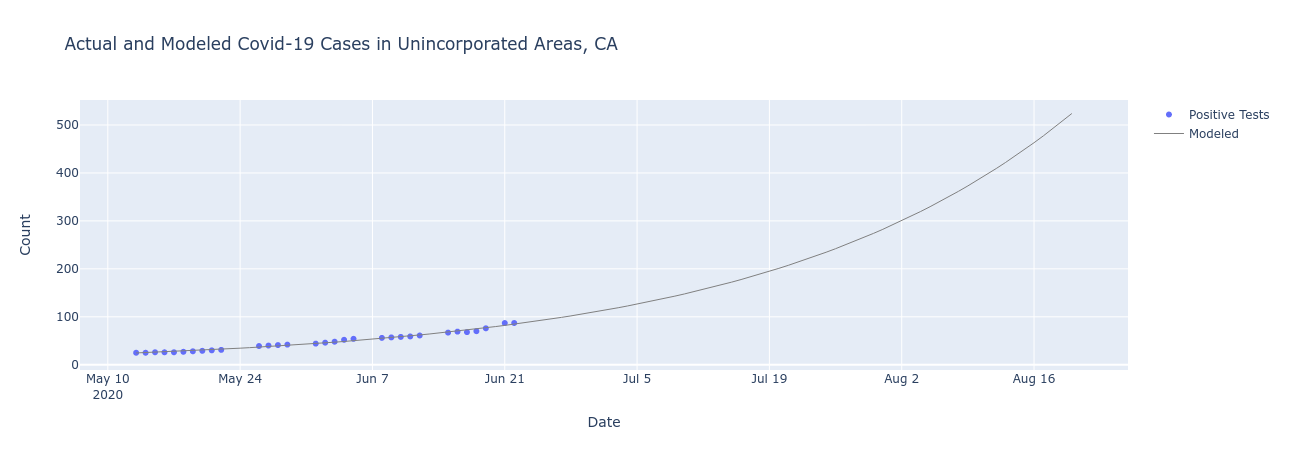

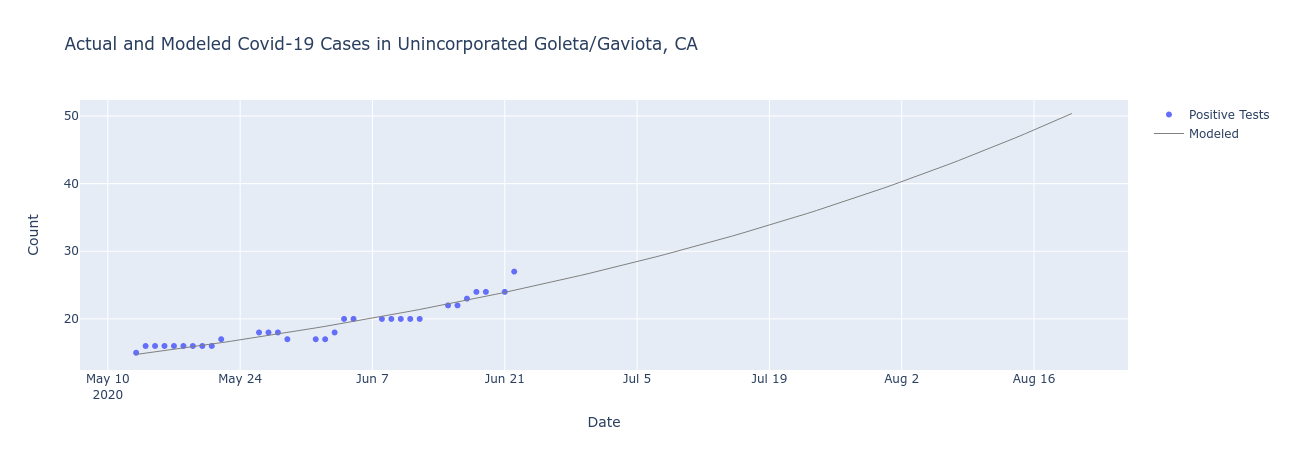

In [9]:
df_list = []
for ga in tclong['Geographic Area'].unique():
    gadf = tclong.query("`Geographic Area` == @ga").sort_values('Date')
    moddf, pcov = predict_and_extend(gadf, 60)
    # Interpolate if you want to do change.
#     moddf['Change (3 day)'] = moddf.Count.pct_change(periods=3) * 100
    moddf['Geographic Area'] = ga
    df_list.append(moddf)
    fig = go.Figure() #px.scatter(mod, x='Date', y='Count', labels='Confirmed Cases')
    fig.add_trace(go.Scatter(
        x=moddf.Date, y=moddf.Count,
        mode='markers', name='Positive Tests',
#         marker=dict(
#              color=moddf['Change (3 day)'],
#             colorscale='Viridis', # one of plotly colorscales
#             showscale=True,
#             cmin=0,
#             cmax=30,
#             colorbar=dict(yanchor='top',
#                          len=0.8,
#                          title="3 Day % Change")
#         ),
        ))
#     
    fig.add_trace(go.Scatter(
        x=moddf.Date, y=moddf['Modeled Count'], 
        mode='lines', name='Modeled', line=dict(width=1, color='gray')))
    fig.update_layout(title=f'Actual and Modeled Covid-19 Cases in {ga}, CA',
                       xaxis_title='Date',
                       yaxis_title='Count')
    
    fig.show()
allmod = pd.concat(df_list)
allmod['Geographic Area'].dropna(inplace=True)